# Digit Recognizer
This is a simple demonstraction of using Resnet blocks on Handwritten digit recognision problem with MINST dataset available on [kaggle](https://www.kaggle.com/c/digit-recognizer) you can get it from there.  

In this notebook, we use it locally from 'Datasets' folder outside the repo, so make sure to have that before running the notebook.

In [31]:
# imports
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten,Activation, BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def read_ds(csv_file, img_sz):
    df = pd.read_csv(csv_file).values
    n = df.shape[0]
    h, w = img_sz
    train_labels = df[:, 0]
    train_images = df[:, 1:].reshape((n, h, w, 1))
    return train_images, train_labels

we have 42000 records in the dataset


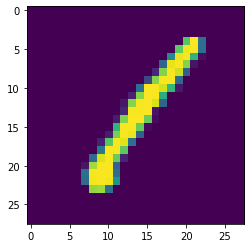

In [8]:
training_images, training_labels = read_ds('../../../Datasets/MINST/digit-recognizer/train.csv', (28, 28))

print('we have {} records in the dataset'.format(training_labels.shape[0]))
plt.imshow(training_images[0].reshape(28, 28))
plt.show()

In [9]:
# Normalization
training_images = training_images / 255.0

In [30]:
# this function simplifies the build of a neural net, by stacking
# layers on top of one another in the pipe, you can easily 
# build a neural net without having to define input and output
# at least not in the pipe.
# it will return a function that will call the functions (the layers) you passed
# in order, we use this function to create the block to be passed to ResBlock function
def pipe(functions):
    def loopOverFuns(X):
        for f in functions:
            X = f(X)
        return X
    return loopOverFuns

## ResBlock
This function takes two parameters  
1. X: the Tensor input to the neural net
2. block: a function of the block of layers you want the input to pass through

Here we only allow identity mapping so the block output size must be same as X.shape

In [20]:
def ResBlock(X, block):
  Y = X
  X = block(X)
  X = tf.keras.layers.Add()([X, Y])
  return X

In [38]:
# create the model
block = lambda X: MaxPool2D()(Conv2D(32, (3,3), padding='same')(X))
block = pipe([
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(axis = 3),
    Activation('relu')
])


X = tf.keras.Input(shape=(28,28,1))
I = Conv2D(32, (3,3))(X)
I = MaxPool2D()(I)
I = ResBlock(I, block)
I = ResBlock(I, block)
I = Flatten()(I)
I = Dense(128, activation=tf.nn.relu)(I)
out = Dense(10, activation=tf.nn.softmax)(I)

model = tf.keras.Model(inputs=[X], outputs=[out])

In [39]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'],
)

In [41]:
model.fit(
    x = training_images,
    y = training_labels,
    epochs=5
)

Train on 42000 samples
Epoch 1/5
42000/42000 [==============================] - 77s 2ms/sample - loss: 0.0888 - accuracy: 0.9726
Epoch 2/5
42000/42000 [==============================] - 82s 2ms/sample - loss: 0.0525 - accuracy: 0.9832
Epoch 3/5
42000/42000 [==============================] - 73s 2ms/sample - loss: 0.0372 - accuracy: 0.9881
Epoch 4/5
42000/42000 [==============================] - 74s 2ms/sample - loss: 0.0321 - accuracy: 0.9899
Epoch 5/5
42000/42000 [==============================] - 75s 2ms/sample - loss: 0.0251 - accuracy: 0.9922


In [42]:
# Testing
test_df = pd.read_csv('../../Kaggle/MINST/digit-recognizer/test.csv').values
test_images = test_df.reshape((test_df.shape[0], 28, 28, 1))

out = model.predict(test_images)

print(out.shape)
print(out)


(28000, 10)
[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


In [43]:
labels = np.argmax(out, axis=1)
print(labels)

[2 0 9 ... 3 9 2]


In [44]:
imageIds = np.arange(1, labels.shape[0]+1, 1)
results = np.array([imageIds, labels]).T
print(results)

[[    1     2]
 [    2     0]
 [    3     9]
 ...
 [27998     3]
 [27999     9]
 [28000     2]]


In [45]:
results_df = pd.DataFrame(results, columns=['ImageId','Label'])
print(results_df)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [46]:
results_df.to_csv('out.csv', index=False)